## LambdaRank Model (training + inference)

Code adapted from https://github.com/houchenyu/L2R/blob/master/lambdaRank.py


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [30]:
data_dir = "/content/drive/MyDrive/data"

# features_fp = os.path.join(data_dir, "candidate-list-features.jsonl")
features_fp = os.path.join(data_dir, "candidate-list-5features.jsonl")
inf_feats_fp = os.path.join(data_dir, "candidate-inf1-feats.jsonl")

model_fp = os.path.join(data_dir, "lambdarank_model.pt")
featscalers_pickle_fp = os.path.join(data_dir, "feat_scalers_3.pickle")
inference_fp = os.path.join(data_dir, "inf3.tsv")

In [5]:
rows = []
with open(features_fp, "r", encoding="utf-8") as f:
  for line in f:
    rows.append(json.loads(line.strip()))

len(rows), len(rows[0])

(5004, 64)

In [6]:
feats_df = pd.DataFrame(rows)
feats_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,label
0,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,3,1,2,5,286,0,0,0,...,4.040502,0.183206,52.409880,6.227678,38.665046,0.817681,0.072743,0.211973,0.604541,4
1,acute cholecystitis child,zvQzvYkBIHFsYVIUsjwX,3,1,1,4,81,0,0,0,...,0.745124,0.115926,29.645081,5.509683,32.488344,0.817681,0.110808,0.251098,0.647505,3
2,acute cholecystitis child,w_QzvYkBIHFsYVIUsjwX,3,1,1,2,269,0,0,0,...,7.302085,0.205532,88.935242,6.872399,111.506575,0.817681,0.004833,0.022811,0.609198,4
3,acute cholecystitis child,1vQzvYkBIHFsYVIUsjwX,3,1,2,3,260,0,0,0,...,1.425995,0.178530,44.552584,6.018126,42.014581,0.817681,0.141400,0.141922,0.503128,4
4,acute cholecystitis child,0PQzvYkBIHFsYVIUsjwX,3,1,2,5,57,0,0,0,...,0.058594,0.044632,13.102470,4.007278,7.067541,0.817681,0.072743,0.211973,0.619005,4


In [7]:
# convert query to numeric qid
unique_queries = feats_df["query"].unique()
query2qid = {q: i for i, q in enumerate(unique_queries)}

feats_df["qid"] = feats_df.apply(lambda row: query2qid[row["query"]], axis=1)
feats_df = feats_df.drop(["query", "doc_id"], axis=1)
feats_df.head()

,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,num_text_token_overlap,title_concept_overlap,...,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,label,qid
0,3,1,2,5,286,0,0,0,2,0,...,0.183206,52.409880,6.227678,38.665046,0.817681,0.072743,0.211973,0.604541,4,0
1,3,1,1,4,81,0,0,0,2,0,...,0.115926,29.645081,5.509683,32.488344,0.817681,0.110808,0.251098,0.647505,3,0
2,3,1,1,2,269,0,0,0,2,0,...,0.205532,88.935242,6.872399,111.506575,0.817681,0.004833,0.022811,0.609198,4,0
3,3,1,2,3,260,0,0,0,2,0,...,0.178530,44.552584,6.018126,42.014581,0.817681,0.141400,0.141922,0.503128,4,0
4,3,1,2,5,57,0,0,0,2,0,...,0.044632,13.102470,4.007278,7.067541,0.817681,0.072743,0.211973,0.619005,4,0


In [8]:
# got these using polars
int_cols = ['num_query_tokens', 'num_title_tokens', 'num_section_title_tokens',
  'num_bread_crumb_tokens', 'num_text_tokens', 'num_title_token_overlap',
  'num_section_title_token_overlap', 'num_bread_crumb_token_overlap',
  'num_text_token_overlap', 'title_concept_overlap', 'section_title_concept_overlap',
  'bread_crumb_concept_overlap', 'text_concept_overlap', 'title_stygroup_overlap',
  'section_title_stygroup_overlap', 'bread_crumb_stygroup_overlap', 'text_stygroup_overlap',
  'title_ttf', 'title_min_tf', 'title_max_tf', 'section_title_ttf', 'section_title_min_tf',
  'section_title_max_tf', 'bread_crumb_ttf', 'bread_crumb_min_tf', 'bread_crumb_max_tf',
  'text_ttf', 'text_min_tf', 'text_max_tf']
float_cols = ['title_bm25_score', 'section_title_bm25_score', 'bread_crumb_bm25_score',
  'text_bm25_score', 'title mean_tf', 'title_var_tf', 'title_min_tfidf',
  'title_max_tfidf', 'title mean_tfidf', 'title_var_tfidf', 'section_title mean_tf',
  'section_title_var_tf', 'section_title_min_tfidf', 'section_title_max_tfidf',
  'section_title mean_tfidf', 'section_title_var_tfidf', 'bread_crumb mean_tf',
  'bread_crumb_var_tf', 'bread_crumb_min_tfidf', 'bread_crumb_max_tfidf',
  'bread_crumb mean_tfidf', 'bread_crumb_var_tfidf', 'text_mean_tf', 'text_var_tf',
  'text_min_tfidf', 'text_max_tfidf', 'text mean_tfidf', 'text_var_tfidf',
  'title_vec_score', 'section_title_vec_score', 'bread_crumb_vec_score', 'text_vec_score']


def scale_features(df, int_cols, float_cols):
  feature_scalers = {}
  for colname in int_cols:
    scaler = MinMaxScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  for colname in float_cols:
    scaler = StandardScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  return feature_scalers


feat_scalers = scale_features(feats_df, int_cols, float_cols)
with open(featscalers_pickle_fp, "wb") as handle:
    pickle.dump(feat_scalers, handle, protocol=pickle.HIGHEST_PROTOCOL)

feats_df.head()

,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,num_text_token_overlap,title_concept_overlap,...,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,label,qid
0,0.142857,0.0,0.1,0.153846,0.592050,0.0,0.0,0.0,0.285714,0.0,...,-0.016440,0.693258,0.291746,-0.024383,2.154886,-0.590673,0.255796,1.434446,4,0
1,0.142857,0.0,0.0,0.115385,0.163180,0.0,0.0,0.0,0.285714,0.0,...,-0.196172,-0.271883,-0.066212,-0.139311,2.154886,-0.323897,0.542139,1.667166,3,0
2,0.142857,0.0,0.0,0.038462,0.556485,0.0,0.0,0.0,0.285714,0.0,...,0.043200,2.241794,0.613173,1.330961,2.154886,-1.066613,-1.128641,1.459674,4,0
3,0.142857,0.0,0.1,0.076923,0.537657,0.0,0.0,0.0,0.285714,0.0,...,-0.028932,0.360139,0.187273,0.037941,2.154886,-0.109492,-0.256893,0.885137,4,0
4,0.142857,0.0,0.1,0.153846,0.112971,0.0,0.0,0.0,0.285714,0.0,...,-0.386627,-0.973226,-0.815240,-0.612309,2.154886,-0.590673,0.255796,1.512791,4,0


In [9]:
X = feats_df.to_numpy()
feats = X[:, 0:-2].astype(np.float32)
labels = X[:, -2].astype(np.float32)
qids = X[:, -1].astype(np.float32)

feats.shape, labels.shape, qids.shape

((5004, 61), (5004,), (5004,))

In [10]:
training_data = np.concatenate([labels.reshape(-1, 1), qids.reshape(-1, 1), feats], axis=1)
training_data.shape

(5004, 63)

In [18]:
n_feature = training_data.shape[1] - 2
h1_units = 512
h2_units = 256
epoch = 100
learning_rate = 1e-4

In [19]:
class Net(nn.Module):
    def __init__(self, n_feature, h1_units, h2_units):
        super(Net, self).__init__()
        self.h1 = nn.Linear(n_feature, h1_units)

        self.h2 = nn.Linear(h1_units, h2_units)

        self.out = nn.Linear(h2_units, 1)

    def forward(self, x):
        x = self.h1(x)
        x = F.relu(x)
        x = self.h2(x)
        x = F.relu(x)
        x = self.out(x)
        return x

net = Net(n_feature, h1_units, h2_units)
output = net(torch.rand(10, n_feature))
output.shape

torch.Size([10, 1])

In [20]:
def dcg(scores):
    """
    compute the DCG value based on the given score
    :param scores: a score list of documents
    :return v: DCG value
    """
    v = 0
    for i in range(len(scores)):
        v += (np.power(2, scores[i]) - 1) / np.log2(i+2)  # i+2 is because i starts from 0
    return v


def idcg(scores):
    """
    compute the IDCG value (best dcg value) based on the given score
    :param scores: a score list of documents
    :return:  IDCG value
    """
    best_scores = sorted(scores)[::-1]
    return dcg(best_scores)


def ndcg(scores):
    """
    compute the NDCG value based on the given score
    :param scores: a score list of documents
    :return:  NDCG value
    """
    return dcg(scores)/idcg(scores)


def single_dcg(scores, i, j):
    """
    compute the single dcg that i-th element located j-th position
    :param scores:
    :param i:
    :param j:
    :return:
    """
    return (np.power(2, scores[i]) - 1) / np.log2(j+2)


def ndcg_k(scores, k):
    scores_k = scores[:k]
    dcg_k = dcg(scores_k)
    idcg_k = dcg(sorted(scores)[::-1][:k])
    if idcg_k == 0:
        return np.nan
    return dcg_k/idcg_k

In [21]:
def group_by(data, qid_index):
    """
    :param data: input_data
    :param qid_index: the column num where qid locates in input data
    :return: a dict group by qid
    """
    qid_doc_map = {}
    idx = 0
    for record in data:
        qid_doc_map.setdefault(record[qid_index], [])
        qid_doc_map[record[qid_index]].append(idx)
        idx += 1
    return qid_doc_map


def get_pairs(scores):
    """
    :param scores: given score list of documents for a particular query
    :return: the documents pairs whose first doc has a higher value than second one.
    """
    pairs = []
    for i in range(len(scores)):
        for j in range(len(scores)):
            if scores[i] > scores[j]:
                pairs.append((i, j))
    return pairs


def compute_lambda(true_scores, temp_scores, order_pairs, qid):
    """
    :param true_scores: the score list of the documents for the qid query
    :param temp_scores: the predict score list of the these documents
    :param order_pairs: the partial oder pairs where first document has higher score than the second one
    :param qid: specific query id
    :return:
        lambdas: changed lambda value for these documents
        w: w value
        qid: query id
    """
    doc_num = len(true_scores)
    lambdas = np.zeros(doc_num)
    w = np.zeros(doc_num)
    IDCG = idcg(true_scores)
    single_dcgs ={}
    for i, j in order_pairs:
        if (i, i) not in single_dcgs:
            single_dcgs[(i, i)] = single_dcg(true_scores, i, i)
        if (j, j) not in single_dcgs:
            single_dcgs[(j, j)] = single_dcg(true_scores, j, j)
        single_dcgs[(i, j)] = single_dcg(true_scores, i, j)
        single_dcgs[(j, i)] = single_dcg(true_scores, j, i)

    for i, j in order_pairs:
        delta = abs(single_dcgs[(i,j)] + single_dcgs[(j,i)] - single_dcgs[(i,i)] -single_dcgs[(j,j)])/IDCG
        rho = 1 / (1 + np.exp(temp_scores[i] - temp_scores[j]))
        lambdas[i] += rho * delta
        lambdas[j] -= rho * delta

        rho_complement = 1.0 - rho
        w[i] += rho * rho_complement * delta
        w[j] -= rho * rho_complement * delta

    return lambdas, w, qid


In [22]:
class LambdaRank:

    def __init__(self, training_data, n_feature, h1_units, h2_units, epoch,
                 lr=0.001, ckpt=None):
        self.training_data = training_data
        self.n_feature = n_feature
        self.h1_units = h1_units
        self.h2_units = h2_units
        self.epoch = epoch
        self.lr = lr
        self.trees = []
        self.model = Net(n_feature, h1_units, h2_units)
        if ckpt is not None:
          state_dict = torch.load(ckpt)
          self.model.load_state_dict(state_dict)
        # for para in self.model.parameters():
        #     print(para[0])
        self.ndcg_training_history = []

    def fit(self):
        """
        train the model to fit the train dataset
        """
        qid_doc_map = group_by(self.training_data, 1)
        query_idx = qid_doc_map.keys()
        # true_scores is a matrix, different rows represent different queries
        true_scores = [self.training_data[qid_doc_map[qid], 0] for qid in query_idx]

        order_paris = []
        for scores in true_scores:
            order_paris.append(get_pairs(scores))

        sample_num = len(self.training_data)
        print('Training .....\n')
        for i in range(self.epoch):
            predicted_scores = self.model(torch.from_numpy(self.training_data[:, 2:].astype(np.float32)))
            predicted_scores_numpy = predicted_scores.data.numpy()
            lambdas = np.zeros(sample_num)
            # w = np.zeros(sample_num)

            pred_score = [predicted_scores_numpy[qid_doc_map[qid]] for qid in query_idx]

            zip_parameters = zip(true_scores, pred_score, order_paris, query_idx)
            for ts, ps, op, qi in zip_parameters:
                sub_lambda, sub_w, qid = compute_lambda(ts, ps, op, qi)
                lambdas[qid_doc_map[qid]] = sub_lambda
                # w[qid_doc_map[qid]] = sub_w
            # update parameters
            self.model.zero_grad()
            lambdas_torch = torch.Tensor(lambdas).view((len(lambdas), 1))
            predicted_scores.backward(lambdas_torch, retain_graph=True)  # This is very important. Please understand why?
            with torch.no_grad():
                for param in self.model.parameters():
                    param.data.add_(param.grad.data * self.lr)


            if i % 1 == 0:
                qid_doc_map = group_by(self.training_data, 1)
                ndcg_list = []
                for qid in qid_doc_map.keys():
                    subset = qid_doc_map[qid]

                    X_subset = torch.from_numpy(self.training_data[subset, 2:].astype(np.float32))
                    sub_pred_score = self.model(X_subset).data.numpy().reshape(1, len(X_subset)).squeeze()

                    # calculate the predicted NDCG
                    true_label = self.training_data[qid_doc_map[qid], 0]
                    k = len(true_label)
                    pred_sort_index = np.argsort(sub_pred_score)[::-1]
                    true_label = true_label[pred_sort_index]
                    ndcg_val = ndcg_k(true_label, k)
                    ndcg_list.append(ndcg_val)
                avg_ndcg = np.nanmean(ndcg_list)
                self.ndcg_training_history.append(avg_ndcg)
                print('Epoch:{}, Average NDCG : {}'.format(i, avg_ndcg))


    def predict(self, data):
        """
        predict the score for each document in testset
        :param data: given testset
        :return:
        """
        qid_doc_map = group_by(data, 1)
        predicted_scores = np.zeros(len(data))
        for qid in qid_doc_map.keys():
            subset = qid_doc_map[qid]
            X_subset = torch.from_numpy(data[subset, 2:].astype(np.float32))
            sub_pred_score = self.model(X_subset).data.numpy().reshape(1, len(X_subset)).squeeze()
            predicted_scores[qid_doc_map[qid]] = sub_pred_score
        return predicted_scores

    def validate(self, data, k):
        """
        validate the NDCG metric
        :param data: given th testset
        :param k: used to compute the NDCG@k
        :return:
        """
        qid_doc_map = group_by(data, 1)
        ndcg_list = []
        predicted_scores = np.zeros(len(data))
        for qid in qid_doc_map.keys():
            subset = qid_doc_map[qid]
            X_subset = torch.from_numpy(data[subset, 2:].astype(np.float32))
            sub_pred_score = self.model(X_subset).data.numpy().reshape(1, len(X_subset)).squeeze()

            # calculate the predicted NDCG
            true_label = data[qid_doc_map[qid], 0]
            k = len(true_label)
            pred_sort_index = np.argsort(sub_pred_score)[::-1]
            true_label = true_label[pred_sort_index]
            ndcg_val = ndcg_k(true_label, k)
            ndcg_list.append(ndcg_val)
        return ndcg_list


### Training

In [23]:
model = LambdaRank(training_data, n_feature, h1_units, h2_units, epoch, learning_rate)
model.fit()

Training .....

Epoch:0, Average NDCG : 0.828359645580609
Epoch:1, Average NDCG : 0.8306046695788776
Epoch:2, Average NDCG : 0.8337235106676244
Epoch:3, Average NDCG : 0.8368399630979446
Epoch:4, Average NDCG : 0.8403607510268057
Epoch:5, Average NDCG : 0.8448192529903806
Epoch:6, Average NDCG : 0.8484810720358124
Epoch:7, Average NDCG : 0.8533248849298041
Epoch:8, Average NDCG : 0.8571110664293746
Epoch:9, Average NDCG : 0.8608259879469274
Epoch:10, Average NDCG : 0.8657674612546432
Epoch:11, Average NDCG : 0.8682266550695704
Epoch:12, Average NDCG : 0.8733173814883457
Epoch:13, Average NDCG : 0.878029082322482
Epoch:14, Average NDCG : 0.8809725357223438
Epoch:15, Average NDCG : 0.8837398984061737
Epoch:16, Average NDCG : 0.8860299760334694
Epoch:17, Average NDCG : 0.8894024944863267
Epoch:18, Average NDCG : 0.8915988157079965
Epoch:19, Average NDCG : 0.8931332515037894
Epoch:20, Average NDCG : 0.8936954096686985
Epoch:21, Average NDCG : 0.8946076956243906
Epoch:22, Average NDCG : 0.8

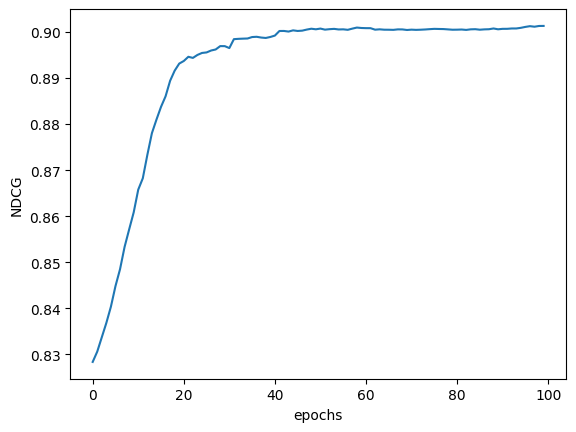

In [24]:
ys = model.ndcg_training_history
xs = np.arange(len(model.ndcg_training_history))
plt.plot(xs, ys)
plt.ylabel("NDCG")
plt.xlabel("epochs")
_ = plt.show()

In [25]:
torch.save(model.model.state_dict(), model_fp)

### Inference

In [27]:
rows = []
with open(inf_feats_fp, "r", encoding="utf-8") as f:
  for line in f:
    rows.append(json.loads(line.strip()))

len(rows), len(rows[0])

(1300, 63)

In [28]:
inf_df = pd.DataFrame(rows)
inf_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_mean_tf,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score
0,Influenza tx + pregnant,o9wzvYkBeOphH9NsHySg,4,1,2,5,206,1,0,0,...,1.598425,1.547399,0.173889,31.856707,3.956062,13.892614,0.661382,0.081131,0.073746,0.622498
1,Influenza tx + pregnant,YvMAvYkBIHFsYVIUKIri,4,3,1,2,149,1,0,0,...,1.600000,1.345882,0.173889,26.547256,3.905038,17.500854,0.499326,0.528598,0.340981,0.643338
2,Influenza tx + pregnant,K-oCvYkBlUvzL_hactoj,4,3,1,1,315,1,0,0,...,1.728395,3.778083,0.245285,47.785060,5.105488,26.088959,0.590800,0.187122,0.187122,0.659157
3,Influenza tx + pregnant,OuoCvYkBlUvzL_hactoj,4,3,1,2,315,1,0,0,...,1.728395,3.778083,0.245285,47.785060,5.105488,26.088959,0.590800,0.528598,0.340981,0.659157
4,Influenza tx + pregnant,NPL7vIkBIHFsYVIUlfNH,4,1,1,2,194,0,0,0,...,1.537037,1.544925,0.201418,42.475609,4.852688,32.859848,0.173295,-0.001387,-0.005145,0.432175


In [31]:
with open(featscalers_pickle_fp, 'rb') as f:
  feat_scalers = pickle.load(f)


def scale_features(df, int_cols, float_cols, feat_scalers):
  for colname in int_cols:
    if colname not in feat_scalers.keys():
      continue
    scaler = feat_scalers[colname]
    df[colname] = scaler.transform(df[colname].values.reshape(-1, 1))
  for colname in float_cols:
    if colname not in feat_scalers.keys():
      continue
    scaler = feat_scalers[colname]
    df[colname] = scaler.transform(df[colname].values.reshape(-1, 1))


scale_features(inf_df, int_cols, float_cols, feat_scalers)
inf_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_mean_tf,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score
0,Influenza tx + pregnant,o9wzvYkBeOphH9NsHySg,0.285714,0.000000,0.1,0.153846,0.424686,0.5,0.0,0.0,...,-0.262191,-0.347519,-0.041329,-0.178118,-0.840774,-0.485317,1.530211,-0.531886,-0.755864,1.531714
1,Influenza tx + pregnant,YvMAvYkBIHFsYVIUKIri,0.285714,0.076923,0.0,0.038462,0.305439,0.5,0.0,0.0,...,-0.260137,-0.396435,-0.041329,-0.403219,-0.866212,-0.418179,0.882527,2.604163,1.199972,1.644593
2,Influenza tx + pregnant,K-oCvYkBlUvzL_hactoj,0.285714,0.076923,0.0,0.000000,0.652720,0.5,0.0,0.0,...,-0.092699,0.193962,0.149398,0.497183,-0.267725,-0.258383,1.248116,0.210950,0.073915,1.730275
3,Influenza tx + pregnant,OuoCvYkBlUvzL_hactoj,0.285714,0.076923,0.0,0.038462,0.652720,0.5,0.0,0.0,...,-0.092699,0.193962,0.149398,0.497183,-0.267725,-0.258383,1.248116,2.604163,1.199972,1.730275
4,Influenza tx + pregnant,NPL7vIkBIHFsYVIUlfNH,0.285714,0.000000,0.0,0.038462,0.399582,0.0,0.0,0.0,...,-0.342246,-0.348119,0.032212,0.272083,-0.393759,-0.132398,-0.420514,-1.110205,-1.333246,0.500821


In [32]:
unique_queries = inf_df["query"].unique()
query2qid = {q: i for i, q in enumerate(unique_queries)}

inf_df["qid"] = inf_df.apply(lambda row: query2qid[row["query"]], axis=1)
# inf_df = inf_df.drop(["query", "doc_id"], axis=1)
inf_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,qid
0,Influenza tx + pregnant,o9wzvYkBeOphH9NsHySg,0.285714,0.000000,0.1,0.153846,0.424686,0.5,0.0,0.0,...,-0.347519,-0.041329,-0.178118,-0.840774,-0.485317,1.530211,-0.531886,-0.755864,1.531714,0
1,Influenza tx + pregnant,YvMAvYkBIHFsYVIUKIri,0.285714,0.076923,0.0,0.038462,0.305439,0.5,0.0,0.0,...,-0.396435,-0.041329,-0.403219,-0.866212,-0.418179,0.882527,2.604163,1.199972,1.644593,0
2,Influenza tx + pregnant,K-oCvYkBlUvzL_hactoj,0.285714,0.076923,0.0,0.000000,0.652720,0.5,0.0,0.0,...,0.193962,0.149398,0.497183,-0.267725,-0.258383,1.248116,0.210950,0.073915,1.730275,0
3,Influenza tx + pregnant,OuoCvYkBlUvzL_hactoj,0.285714,0.076923,0.0,0.038462,0.652720,0.5,0.0,0.0,...,0.193962,0.149398,0.497183,-0.267725,-0.258383,1.248116,2.604163,1.199972,1.730275,0
4,Influenza tx + pregnant,NPL7vIkBIHFsYVIUlfNH,0.285714,0.000000,0.0,0.038462,0.399582,0.0,0.0,0.0,...,-0.348119,0.032212,0.272083,-0.393759,-0.132398,-0.420514,-1.110205,-1.333246,0.500821,0


In [ ]:
with open(inference_fp, "w", encoding="utf-8") as fout:
  for query in unique_queries:
    print("processing query: {:s}".format(query))
    sub_df = inf_df[inf_df["query"] == query]
    doc_ids = sub_df.iloc[:, 1].tolist()
    feats = sub_df.iloc[:, 2:-1].to_numpy()
    labels = np.zeros((len(sub_df), 1))
    qids = sub_df.iloc[:, -1].to_numpy().astype(np.float32)
    test_data = np.concatenate([labels, qids.reshape(-1, 1), feats], axis=1)
    preds = model.predict(test_data)
    sorted_ids = np.argsort(preds)[::-1][0:10]
    for i in sorted_ids:
      fout.write("\t".join([query, doc_ids[i], "{:.3f}".format(preds[i])]) + "\n")